<a href="https://colab.research.google.com/github/jayant0146/Portfolio-Optimization/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf # Yahoo finance allows to read the stocks prices
import pandas as pd   # Allows to put data into the data tables
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize # numpy and scipy allows for the statistical methods required

Declare the list of stocks and the starting date and the date 5 years back

In [ ]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']
end_date = datetime.today()
start_date = end_date - timedelta(5 * 365)
print(start_date)

2019-07-31 09:56:19.452531


# Declaring the Adjusted Close Price
Adjusted close Price are far away better than the normal close price as it accounts for corporate actions such as dividends and stock splits. The adjusted closing price ensures the accurate reflection of the historical stock price data on the stock's real performance over a period. While the closing price simply refers to the cost of shares at the end of the day

In [ ]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
  data = yf.download(ticker, start = start_date, end = end_date)
  adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-07-31  274.904114  72.717323  133.210007  185.118408  140.549820
2019-08-01  272.510223  73.238091  136.410004  184.198135  139.247803
2019-08-02  270.458344  73.308327  135.889999  181.485794  138.121262
2019-08-05  262.324860  73.624474  137.789993  175.073013  134.021393
2019-08-06  266.003418  73.808861  138.910004  177.523834  135.766632
...                ...        ...         ...         ...         ...
2024-07-22  554.650024  72.690002  221.800003  482.320007  273.890015
2024-07-23  553.780029  72.699997  222.580002  480.619995  273.690002
2024-07-24  541.229980  72.489998  221.800003  463.380005  267.529999
2024-07-25  538.409973  72.650002  218.330002  458.269989  266.500000
2024-07-26  544.440002  72.940002  220.630005  462.970001  269.690002

[1256 rows x 5 columns]


# Calculate the daily returns (lognormal) for each ticker
Logarithmic returns are important in finance because they provide a more accurate measure of the percentage change in the value of an asset over a period of time.

In [ ]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

# Calulate the Covariance Matrix

In [ ]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.044244  0.002994  0.004024  0.049951  0.045293
BND  0.002994  0.004852  0.003920  0.003612  0.003191
GLD  0.004024  0.003920  0.023423  0.005339  0.004260
QQQ  0.049951  0.003612  0.005339  0.065018  0.051062
VTI  0.045293  0.003191  0.004260  0.051062  0.046747


# Defining Portfolio Performance Metrics
Portfolio Standard Deviation, Expected returns(Based on historical returns), and the Sharp Ratio

In [ ]:
def standard_deviation(weights, cov_matrix) :
  variance = weights.T @ cov_matrix @ weights
  return np.sqrt(variance)

In [ ]:
def expected_return (weights, log_returns):
  return np.sum(log_returns.mean() * weights) * 252

In [ ]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) :
  return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [ ]:
risk_free_rate = 0.02 #Often assumed to be 2%

In [ ]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) :
  return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Since scipy library only has the minimise function, and we're supposed to find the maximum

# Setting the constraints and the bounds

In [ ]:
constraints = {'type' : 'eq', 'fun' : lambda weights : np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

In [ ]:
initial_weights = np.array([1 / len(tickers)] * len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


# Optimise the weights to maximise the sharp ratio

In [ ]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args = (log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints = constraints, bounds = bounds)

print(optimized_results)
# SLSQP method stands for Standard Least Squares Quadratic Programming which is the numerical optimization technique  for solviong non linear optimization with constraints

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.7793942972425021
       x: [ 8.327e-17  1.136e-16  5.000e-01  5.000e-01  9.368e-17]
     nit: 5
     jac: [-2.283e-02  1.145e-01 -1.913e-01 -6.283e-02  3.870e-02]
    nfev: 30
    njev: 5


In [ ]:
optimal_weights = optimized_results.x #Refers to the X Axis of these results

#Display Analytics of the Optimal Portfolio

In [ ]:
print("Optimal Weights are: ")
for ticker, weight in zip(tickers, optimal_weights):
  print(f"{ticker}: {weight:.5f}")

Optimal Weights are: 
SPY: 0.00000
BND: 0.00000
GLD: 0.50000
QQQ: 0.50000
VTI: 0.00000


In [ ]:
# By the above results, it's benefitted to put in Gold and NAsdaqq and nothing to anywhere else
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual return {optimal_portfolio_return:.5f}")
print(f"Expected Voilatility {optimal_portfolio_volatility:.5f}")
print(f"Expected Sharpe ratio {optimal_sharpe_ratio:.5f}")

Expected Annual return 0.14269
Expected Voilatility 0.15742
Expected Sharpe ratio 0.77939


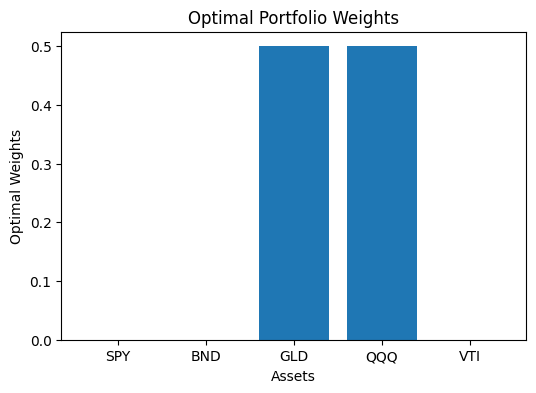

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (6, 4))
plt.bar(tickers, optimal_weights)

plt.xlabel("Assets")
plt.ylabel("Optimal Weights")
plt.title("Optimal Portfolio Weights")

plt.show()